In [1]:
import numpy as np
import pandas as pd
import functions as fn
import matplotlib.pyplot as plt
import seaborn as sns

def MAD_mean_ratio(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

sns.set(style='darkgrid')

#original data from sharadar quandl fundamental data had a different format
#the fundamental data from WRDS comes already staked
#stacked means the data for each ticker=stock is stacked in a pile one on top of the next
#the model here is completely cross sectional, does not consider the timeseries structure of the data

dfroe = pd.read_csv("mixed_cap_roe_UNSTACKED.csv")
dfdates = dfroe.datetime
dfroe.drop(['datetime'], axis=1, inplace=True)
dfroe.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
dfpio = pd.read_csv("mixed_cap_piotroski_UNSTACKED.csv")
dfpio.drop(['datetime'], axis=1, inplace=True)
dfpio.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)

dfpermnos = pd.read_csv("mixed_cap_permnos_with_wrds_data.csv")
syms1=dfpermnos.permno.tolist()
symsP=dfpermnos.permno.tolist()

dfidates = pd.DatetimeIndex(dfdates)
dates1=dfidates


#need to build a df with mid prices unstacked, each column is mid prices for one stock
#this is the daily close mid_price, upon which all return calcs will be based
dfmp = pd.read_csv("mixed_cap_mid_price_UNSTACKED.csv")
dfmp.drop(['datetime'], axis=1, inplace=True)
dfmp.replace([np.inf, -np.inf, np.NINF, -np.NINF], np.nan, inplace=True)
mid=dfmp

#need to build a df with 1Day returns, each column is for one stock
Ret1 = fn.calculateReturns(mid.copy(), 1) #df, 


# hold for 21 days (1 month)
holdingDays = 21

# monthly return
RetM = fn.calculateReturns(mid.copy(), holdingDays) #df, monthly returns calculated daily
#del matP

# shifted next month's return to today's row to use as response variable.
# Can enter only at next day's close.
RetFut = RetM.copy().shift(-(holdingDays+1)) #df, monthly returns calculated daily shifted to today

#del RetM, mid


#############################
m = RetFut.shape[0]
trainSize = m // 2               #
testSize = m - trainSize         #
#############################


RetFutTrain = RetFut.iloc[:trainSize] #df, 
RetFutTest = RetFut.iloc[trainSize:] #df, 
Ret1train = Ret1.iloc[:trainSize] #df, 
Ret1test = Ret1.iloc[trainSize:] #df, 

#flattening and repetition of the date vector, this is the height of daily calculated return column after stacking of stocks
flat_train = RetFutTrain.size #
flat_test = RetFutTest.size #
m0 = RetFut.shape[0] #original number of observations, 
nStocks = len(syms1) #original number of stocks,

datesTrain = dates1.to_numpy()[:trainSize].flatten() #daily dates, 
datesTest = dates1.to_numpy()[trainSize:].flatten() #daily dates, 

#del dates1, datesP, RetFut

# Combine different independent variables into one matrix X for training
X_train = np.nan * np.empty((trainSize * len(symsP), 2)) #
X_test = np.nan * np.empty((testSize * len(symsP), 2)) #
# Combine different independent variables into one matrix X for training
#X_train = np.nan * np.empty((trainSize * len(symsP), 4)) #
#X_test = np.nan * np.empty((testSize * len(symsP), 4)) #

# dependent variable, stacked and divided into train and test
RetFutTrain = pd.DataFrame(np.where(RetFutTrain>0,1,0)) #categorical tag for logistic
RetFutTest = pd.DataFrame(np.where(RetFutTest>0,1,0)) #categorical tag for logistic
y_train = RetFutTrain.to_numpy().flatten()[:,np.newaxis] #arr, 
y_test = RetFutTest.to_numpy().flatten()[:,np.newaxis] #arr, 

ROE = dfroe
ROE.fillna(value=-99.5, inplace=True) #substitutes NA (not available) and NAN (not a number)
ROE[ROE <= 0] = np.nan #gets rid of all negative values of ROE when dropna is applied eventually

 
PIO = dfpio
PIO.fillna(value=-99.5, inplace=True) #substitutes NA (not available) and NAN (not a number)
PIO[PIO <= 0] = np.nan #gets rid of all negative values of PIO when dropna is applied eventually


#At this point PIO and ROE are dfs with shape row*cols
#But now we are going to take the columns and stack them to verical shape
X_train[:,0] = np.log1p(PIO.iloc[:trainSize].to_numpy()).flatten() #numpy.ndarray, 
X_train[:,1] = np.log1p(ROE.iloc[:trainSize].to_numpy()).flatten() #numpy.ndarray, 

X_test[:,0] = np.log1p(PIO.iloc[trainSize:].to_numpy()).flatten() #numpy.ndarray, 
X_test[:,1] = np.log1p(ROE.iloc[trainSize:].to_numpy()).flatten() #numpy.ndarray, 

#Dropna allows the number of rows in XY_train to be reduced, the third column being the added Y
#the dropna is eliminating any rows where PIO and ROE columns have NaN, keeping only those rows
#where there is PIO, ROE and return data (monthly data). We need to keep the dropna
XY_train = pd.DataFrame(np.hstack([X_train, y_train])).dropna(how='any', axis=0) #df, 
XY_test = pd.DataFrame(np.hstack([X_test, y_test])).dropna(how='any', axis=0) #df, 

ixCleanTrain = XY_train.index.to_numpy()
ixCleanTest = XY_test.index.to_numpy()

XY_train = XY_train.to_numpy()
XY_test = XY_test.to_numpy()

X_train, y_train = XY_train[:, 0:-1], XY_train[:, -1][:,np.newaxis]
X_test, y_test = XY_test[:, 0:-1], XY_test[:, -1][:,np.newaxis]

In [2]:
train_data = pd.DataFrame(XY_train)
train_data.to_csv('traindata.csv', index=False)

In [3]:
#Tuned model
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# fit model
model = XGBClassifier(learning_rate=0.01, n_estimators=300, colsample_bytree=0.1, max_depth=6, gamma=0, reg_alpha=1)
model.fit(X_train, y_train)

#By default, the predictions made by XGBoost are probabilities. 
#Because this is a binary classification problem, each prediction is 
#the probability of the input pattern belonging to the first class. 
#We can easily convert them to binary class values by rounding them to 0 or 1.

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\Mike\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Mike\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[22:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 56.13%


In [4]:
# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# CV model
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[22:41:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Mike\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


[22:41:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

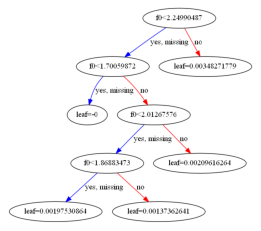

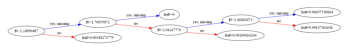

In [5]:
# plot decision tree
from xgboost import plot_tree
from matplotlib import pyplot
from matplotlib.pylab import rcParams

%matplotlib inline
# figure size
#rcParams['figure.figsize'] = 20, 20

# plot single tree
plot_tree(model)
plot_tree(model, num_trees=0, rankdir='LR')

pyplot.show()

[0]	validation_0-error:0.43586	validation_0-logloss:0.69297	validation_1-error:0.44063	validation_1-logloss:0.69302
[1]	validation_0-error:0.43480	validation_0-logloss:0.69276	validation_1-error:0.43882	validation_1-logloss:0.69290
[2]	validation_0-error:0.43480	validation_0-logloss:0.69258	validation_1-error:0.43882	validation_1-logloss:0.69278
[3]	validation_0-error:0.43480	validation_0-logloss:0.69238	validation_1-error:0.43868	validation_1-logloss:0.69266
[4]	validation_0-error:0.43480	validation_0-logloss:0.69222	validation_1-error:0.43882	validation_1-logloss:0.69254
[5]	validation_0-error:0.43480	validation_0-logloss:0.69205	validation_1-error:0.43882	validation_1-logloss:0.69243
[6]	validation_0-error:0.43480	validation_0-logloss:0.69186	validation_1-error:0.43882	validation_1-logloss:0.69232
[7]	validation_0-error:0.43480	validation_0-logloss:0.69167	validation_1-error:0.43868	validation_1-logloss:0.69222
[8]	validation_0-error:0.43480	validation_0-logloss:0.69151	validation_1

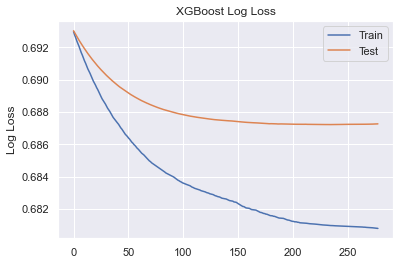

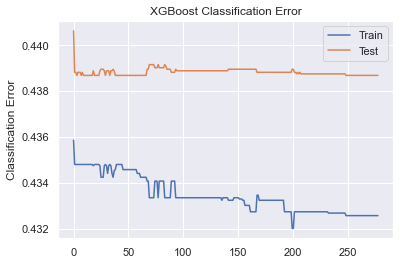

In [6]:
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

# fit model on training data
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set,
verbose=True, early_stopping_rounds=50)

# make predictions for test data
predictions = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

Number of observations: 767
score-training-w/score = 0.5672631989741874
accuracy_score-training = 0.5673
In-sample: CAGR=0.301452 Sharpe ratio=1.04871 maxDD=-0.279148 maxDDD=139 Calmar ratio=1.0799
shorts?:  1.0


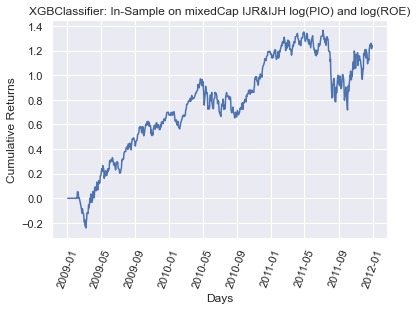

In [7]:
from sklearn.metrics import accuracy_score

print(('Number of observations: {:d}').format(trainSize))

print(('score-training-w/score = {}').format(model.score(X_train, y_train)))

#predict on train
Ypred = model.predict(X_train)

print(('accuracy_score-training = {:.4f}').format(accuracy_score(y_train, Ypred)))

retPred = np.nan * np.empty((flat_train, 1))
Ypred = np.reshape(Ypred,(Ypred.shape[0],1))
retPred[ixCleanTrain] = Ypred
retPred = retPred.reshape(RetFutTrain.shape)

def compare_nan_array(func, a, thresh):
    out = ~np.isnan(a)
    out[out] = func(a[out] , thresh)
    return out

longs = pd.DataFrame(compare_nan_array(np.greater, retPred, .5).astype(int)).shift(1) #1 day later
shorts = pd.DataFrame(compare_nan_array(np.less, retPred, .5).astype(int)).shift(1)

longs.iloc[0] = 0
shorts.iloc[0] = 0

positions = np.zeros(retPred.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.to_numpy(dtype=bool)
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.to_numpy(dtype=bool)
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1train.fillna(0).to_numpy()), axis=1)
dPos = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

dailyRet = np.divide(dRetA, dPos, out=np.zeros_like(dRetA), where=dPos!=0)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1

plt.figure(1)
plt.xticks(rotation=70) 
plt.plot(datesTrain, cumret)
plt.title('XGBClassifier: In-Sample on mixedCap IJR&IJH log(PIO) and log(ROE)')
plt.ylabel('Cumulative Returns')
plt.xlabel('Days')

cagr = (1 + cumret[-1]) ** (252 / trainSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
print(('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

print("shorts?: ", shorts.max().max())

accuracy_score-testing = 0.5612
Out-of-sample: CAGR=0.250985 Sharpe ratio=1.50101 maxDD=-0.132382 maxDDD=128 Calmar ratio=1.89591


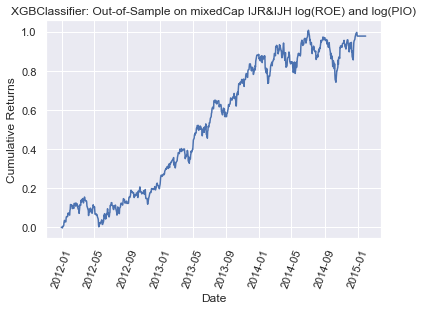

shorts?:  1.0


In [8]:
# Make real predictions on test (out-of-sample)
Ypred = model.predict(X_test)

print(('accuracy_score-testing = {:.4f}').format(accuracy_score(y_test, Ypred)))

retPred = np.nan * np.empty((RetFutTest.size, 1))
Ypred = np.reshape(Ypred,(Ypred.shape[0],1))
retPred[ixCleanTest] = Ypred
retPred = retPred.reshape(RetFutTest.shape)

longs = pd.DataFrame(compare_nan_array(np.greater, retPred, .5).astype(int)).shift(1) #1 day later: probabilities
shorts = pd.DataFrame(compare_nan_array(np.less, retPred, .5).astype(int)).shift(1) #1 day later: probabilities

longs.iloc[0] = 0
shorts.iloc[0] = 0

positions = np.zeros(retPred.shape)

for h in range(holdingDays):
    long_lag = longs.shift(h)
    long_lag.fillna(value=0, inplace=True)
    long_lag = long_lag.to_numpy(dtype=bool)
    
    short_lag = shorts.shift(h)
    short_lag.fillna(value=0, inplace=True)
    short_lag = short_lag.to_numpy(dtype=bool)
    
    positions[long_lag] += 1
    positions[short_lag] -= 1

dRetA = np.sum(np.multiply(pd.DataFrame(positions).shift(1).fillna(0).to_numpy().squeeze(), Ret1test.fillna(0).to_numpy()), axis=1)
dPos = np.sum(pd.DataFrame(positions).shift(1).abs().to_numpy().squeeze(), axis=1)

dailyRet = np.divide(dRetA, dPos, out=np.zeros_like(dRetA), where=dPos!=0)
dailyRet[~np.isfinite(dailyRet)] = 0
cumret = np.cumprod(1 + dailyRet) - 1

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(2)
plt.xticks(rotation=70) 
plt.plot(datesTest, cumret)
plt.title('XGBClassifier: Out-of-Sample on mixedCap IJR&IJH log(ROE) and log(PIO)')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')

cagr = (1 + cumret[-1]) ** (252 / testSize) - 1
maxDD, maxDDD, _ = fn.calculateMaxDD(cumret)
ratio = (252.0 ** 0.5) * np.mean(dailyRet) / np.std(dailyRet)
print(('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

plt.show() 
print("shorts?: ",shorts.max().max())